# Анализ отменённых заказов такси

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

## Описание данных

In [3]:
df = pd.read_csv('./datasets/data_orders.csv')

In [4]:
df.head()

order_datetime  origin_longitude  origin_latitude  m_order_eta   
0       18:08:07         -0.978916        51.456173         60.0  \
1       20:57:32         -0.950385        51.456843          NaN   
2       12:07:50         -0.969520        51.455544        477.0   
3       13:50:20         -1.054671        51.460544        658.0   
4       21:24:45         -0.967605        51.458236          NaN   

        order_gk  order_status_key  is_driver_assigned_key   
0  3000583041974                 4                       1  \
1  3000583116437                 4                       0   
2  3000582891479                 4                       1   
3  3000582941169                 4                       1   
4  3000583140877                 9                       0   

   cancellations_time_in_seconds  
0                          198.0  
1                          128.0  
2                           46.0  
3                           62.0  
4                            NaN

* `order_datetime` - время создания заказа
* `origin_longitude`, `origin_latitude` - координаты (долгота и широта) заказа
* `m_order_eta` - ожидаемое время прибытия такси
* `order_gk` - номер заказа
* `order_status_key` - код статуса:
    - `4` - отменен клиентом;
    - `9` - отменен системой.
* `is_driver_assigned_key` - был ли назначен водитель
* `cancellation_time_in_seconds` - сколько секунд прошло до отмены

In [5]:
df.shape

(10716, 8)

## Задания

### 1. Постройте распределение отменённых заказов: до и после назначения водителя, а также по причинам отмены заказа. В какой категории больше всего заказов?

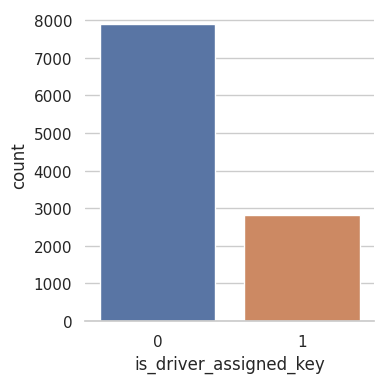

In [6]:
g1 = sns.catplot(data=df, x='is_driver_assigned_key', kind='count', height=4)
g1.despine(left=True)
g1.savefig('./figures/1.png')

In [7]:
df['is_driver_assigned_key'].value_counts(normalize=True)

is_driver_assigned_key
0    0.737402
1    0.262598
Name: proportion, dtype: float64

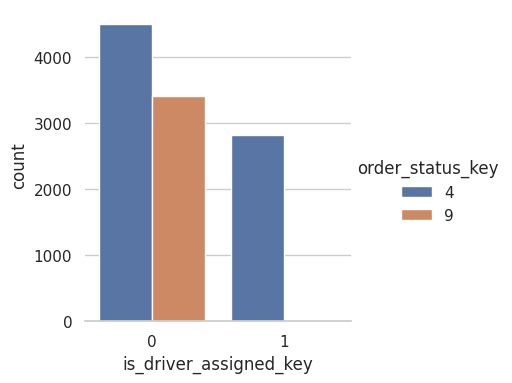

In [8]:
g2 = sns.catplot(data=df, x='is_driver_assigned_key', 
                 kind='count', height=4, hue='order_status_key'
                )
g2.despine(left=True)
g2.savefig('./figures/2.png')

In [9]:
df.groupby(['is_driver_assigned_key', 'order_status_key']).size().reset_index(name='counts')

is_driver_assigned_key  order_status_key  counts
0                       0                 4    4496
1                       0                 9    3406
2                       1                 4    2811
3                       1                 9       3

**Вывод: Большая часть заказов (73,7%) была отменена до назначения водителя. В этом случае, не наблюдается значительной разницы между количеством заказов, отменённых клиентом и отменённых системой, 57% и 43% соответственно. Заказы, в которых водитель был назначен, отменялись преимущественно пользователями.**

### 2. Постройте график распределения невыполненных заказов по часам. Существует ли тенденция, что в определенные часы доля заказов той или иной категории аномально высока? В какие часы происходит больше всего отказов? Как это можно объяснить?

In [10]:
# добавим признак, определяющий час формирования заказа
df['hour'] = df['order_datetime'].map(lambda x: x[:2])

In [11]:
df.head(2)

order_datetime  origin_longitude  origin_latitude  m_order_eta   
0       18:08:07         -0.978916        51.456173         60.0  \
1       20:57:32         -0.950385        51.456843          NaN   

        order_gk  order_status_key  is_driver_assigned_key   
0  3000583041974                 4                       1  \
1  3000583116437                 4                       0   

   cancellations_time_in_seconds hour  
0                          198.0   18  
1                          128.0   20

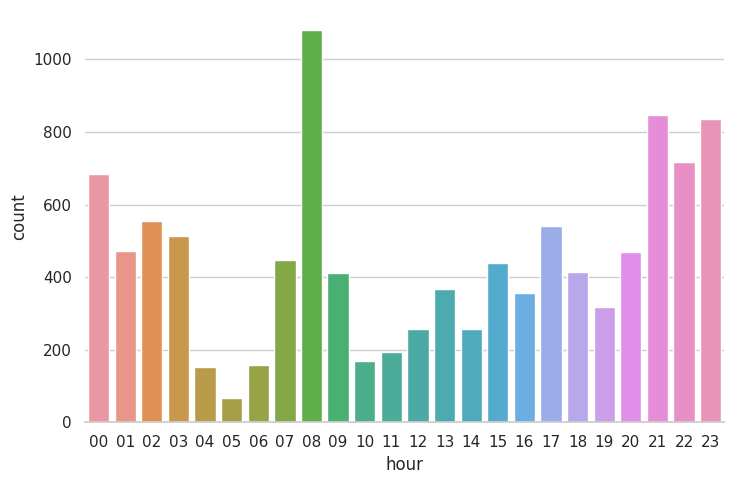

In [12]:
g3 = sns.catplot(data=df, x='hour', kind='count'
                , height=5, aspect=1.5
                , order=[f'{h:02}' for h in range(24)]
               )
g3.despine(left=True)
g3.savefig('./figures/3.png')

In [13]:
top5_failed_hours = df.value_counts('hour').nlargest(5).reset_index()
top5_failed_hours

hour  count
0   08   1082
1   21    846
2   23    836
3   22    716
4   00    683

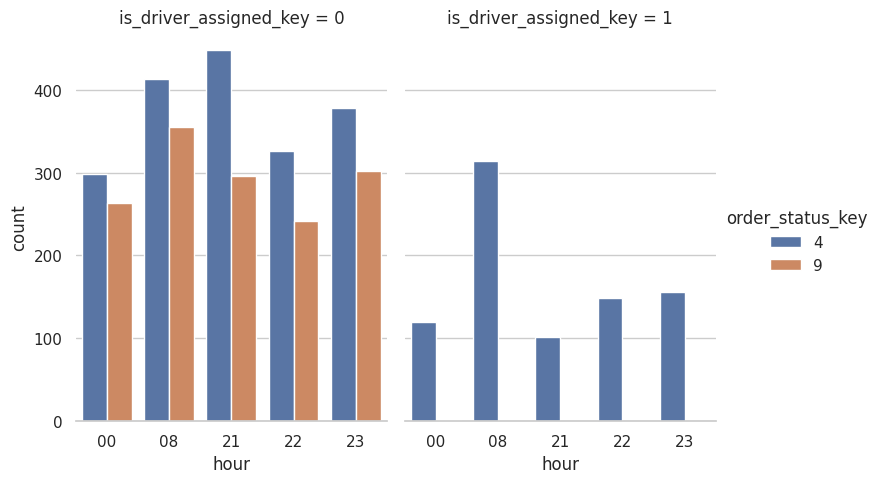

In [14]:
g4 = sns.catplot(data=df[df['hour'].isin(top5_failed_hours['hour'])], x='hour', kind='count'
                , height=5, aspect=0.75
                , order=top5_failed_hours['hour'].sort_values()
                , col='is_driver_assigned_key', hue='order_status_key'
               )
g4.despine(left=True)
g4.savefig('./figures/4.png')

**Вывод: Больше всего отказов происходит в восемь часов утра - время, когда люди едут на работу, и могут отменять заказы из-за большого времени ожидания машины; и в период с девяти вечера до часу ночи - снижается количество общественного транспорта на дорогах, увеличивается количество заказов такси и время прибытия. При рассмотрении ТОП-5 часов с наибольшим количеством невыполненных заказов, сохраняется тенденция сопоставимого числа отмен клиентом и системой при отказе до назначения водителя, и подавляющем большинстве отказов клиентом в случаях, если водитель был назначен.**

### 3. Постройте график среднего времени до отмены заказа с водителем и без водителя по часам. Можно ли сделать какие-либо выводы из этого графика?

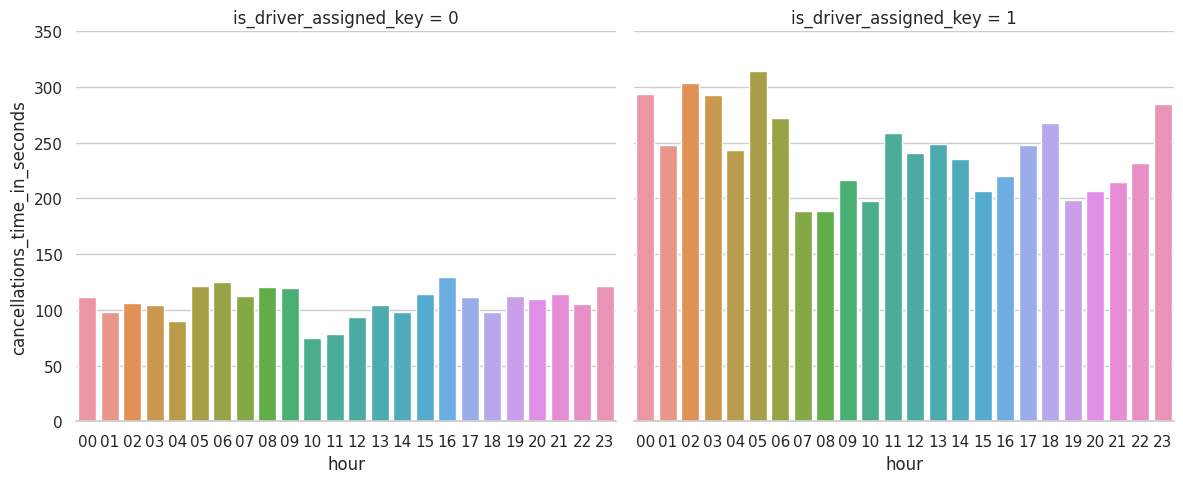

In [15]:
g5 = sns.catplot(data=df, order=[f'{h:02}' for h in range(24)], kind="bar"
                , x="hour", y="cancellations_time_in_seconds", col="is_driver_assigned_key"
                , height=5, aspect=1.2
                , errorbar=None
)
g5.set(ylim=(0, 350))
g5.despine(left=True)
g5.savefig('./figures/5.png')

**Вывод: Среднее время до отмены заказа с назначенным водителем в любое время суток больше, чем в случаях, когда водитель не был назначен.**

### 4. Постройте график распределения среднего времени прибытия по часам. Как можно объяснить этот график?

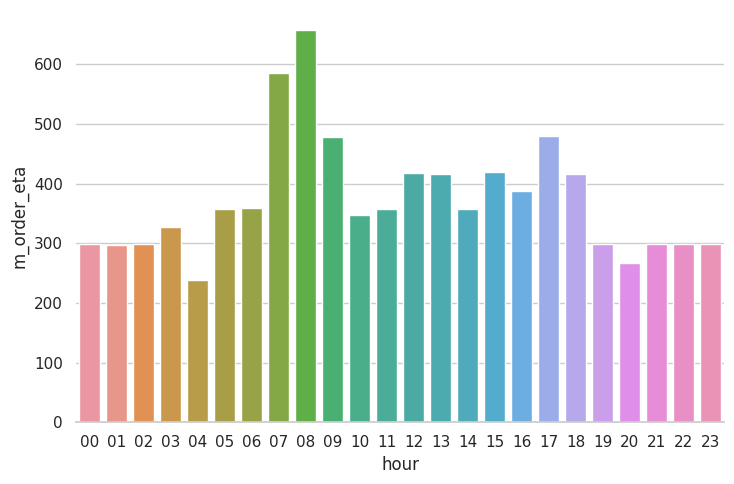

In [16]:
g6 = sns.catplot(data=df, order=[f'{h:02}' for h in range(24)]
                 , x="hour", y="m_order_eta", kind='bar'
                 , height=5, aspect=1.5
                 , errorbar=None, estimator='median'
                 )
g6.despine(left=True)
g6.savefig('./figures/6.png')

**Вывод: Наибольшее ожидаемое время прибытия такси наблюдается в час пик: утром с 7 до 9 и вечером с 17 до 18.**

### 5. Используя *h3* и *folium*, рассчитайте, сколько гексагонов размера 8 содержат 80% всех заказов из исходных наборов данных, и визуализируйте эти гексы, раскрасив их по количеству отказов на карте.

In [17]:
import main

In [18]:
main.make_failed_orders_map(df)

In [19]:
orders_in_h3_cells = main.count_orders_in_h3_cell(df)
gdf = main.add_geometry(orders_in_h3_cells)

In [20]:
main.make_choropleth_maps(gdf)

**Вывод: Наибольшее количество отмен заказов происходит в центре. Что, вероятно, связано с большим количеством создаваемых заказов в этой части города, и более плотным движением, увеличивающим время прибытия такси. Распределение заказов по ячейкам h3 представлено на карте, чем интенсивнее заливка, тем больше заказов было отменено в этой зоне.**